<a href="https://colab.research.google.com/github/OctaviaCosby/AI-Image-Detector/blob/main/Capstone_Project_AI_Art_Image_Detector_Octavia_Cosby.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EfficientNetB0 Model

### Import the libraries

In [2]:
!pip install tensorflow_hub

In [3]:
pip install tf_keras

In [4]:
!pip install tensorflow numpy matplotlib opencv-python

In [42]:
#import the libraries
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, roc_curve

### Load efficientnetb0 base model

In [6]:
#load the base
base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable= False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Create the parameters for custom model

In [7]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.2)(x)
outputlayer = Dense(1, activation = "sigmoid")


### Create the model

In [8]:
detector_enb0 = Model(inputs=base.input, outputs=outputlayer(x))

#compile
detector_enb0.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

detector_enb0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Set training parameters

In [9]:
#rescale and normalize data
datagen_train_enb0 = ImageDataGenerator(rescale = 1.0/255, rotation_range = 30, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split= 0.2)

### set up train and test data parameters


In [68]:
#unzip file
import zipfile

with zipfile.ZipFile("/content/imagedataset.zip", "r") as dataset:
  dataset.extractall("/content/imagedataset/")

train_detector_enb0 = datagen_train_enb0.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "training")

validation_detector_enb0 = datagen_train_enb0.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "validation")

Found 861 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


###Train the model

In [19]:
history_enb0 = detector_enb0.fit(train_detector_enb0, epochs=100, validation_data = validation_detector_enb0)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5028 - loss: 2.4760 - val_accuracy: 0.5000 - val_loss: 1.7765
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4911 - loss: 1.7277 - val_accuracy: 0.5000 - val_loss: 0.7972
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4881 - loss: 0.8977 - val_accuracy: 0.5000 - val_loss: 0.6955
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5298 - loss: 0.8284 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5004 - loss: 0.8010 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5066 - loss: 0.8003 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4834 - loss: 0.7813 - val_accuracy: 0.5000 - val_loss: 0.6958
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5162 - loss: 0.7419 - val_accuracy: 0.5000 - v

In [21]:
print(history_enb0.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [22]:
#plot accuracy vs validation accuracy before fine tuning

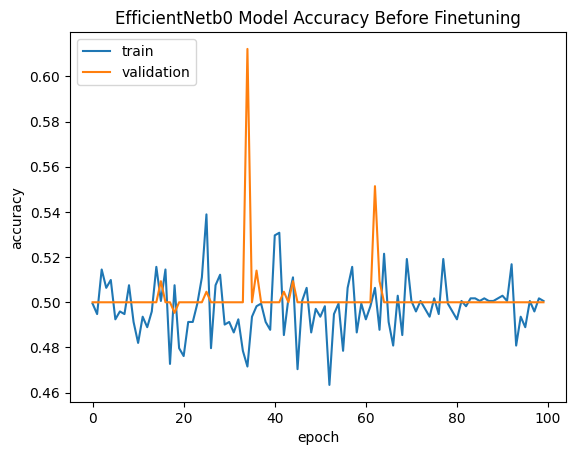

In [23]:
plt.plot(history_enb0.history['accuracy'])
plt.plot(history_enb0.history['val_accuracy'])
plt.title("EfficientNetb0 Model Accuracy Before Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### Loss Before Finetuning

<function matplotlib.pyplot.show(close=None, block=None)>

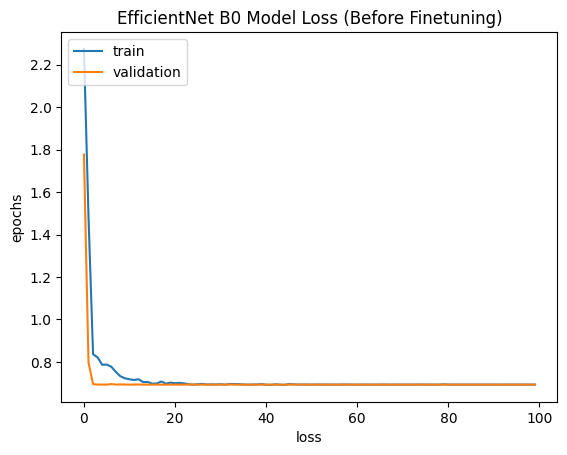

In [30]:
plt.plot(history_enb0.history['loss'])
plt.plot(history_enb0.history['val_loss'])
plt.title("EfficientNet B0 Model Loss (Before Finetuning)")
plt.xlabel("loss")
plt.ylabel("epochs")
plt.legend(["train", "validation"], loc="upper left")
plt.show


### Display Accuracy

### Fine tune the model

In [31]:
base.trainable = True

detector_enb0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

history_finetune_enb0= detector_enb0.fit(train_detector_enb0, epochs=5, validation_data = validation_detector_enb0)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.5810 - loss: 0.7142 - val_accuracy: 0.4673 - val_loss: 0.6933
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5848 - loss: 0.6715 - val_accuracy: 0.4206 - val_loss: 0.6937
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6215 - loss: 0.6597 - val_accuracy: 0.4533 - val_loss: 0.6929
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6337 - loss: 0.6397 - val_accuracy: 0.5140 - val_loss: 0.6923
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6837 - loss: 0.6091 - val_accuracy: 0.4626 - val_loss: 0.6925


### model evaluation

In [33]:
val_loss, val_accuracy = detector_enb0.evaluate(validation_detector_enb0)
print(f"Validation Accuracy: {val_accuracy:.7f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 731ms/step - accuracy: 0.5897 - loss: 0.6911
Validation Accuracy: 0.5514019


### Plot accuracy after fine tuning

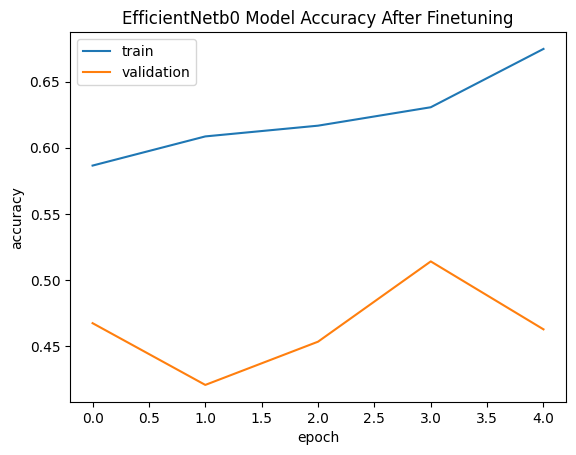

In [35]:
plt.plot(history_finetune_enb0.history['accuracy'])
plt.plot(history_finetune_enb0.history['val_accuracy'])
plt.title("EfficientNetb0 Model Accuracy After Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### Plot Loss After Finetuning

<function matplotlib.pyplot.show(close=None, block=None)>

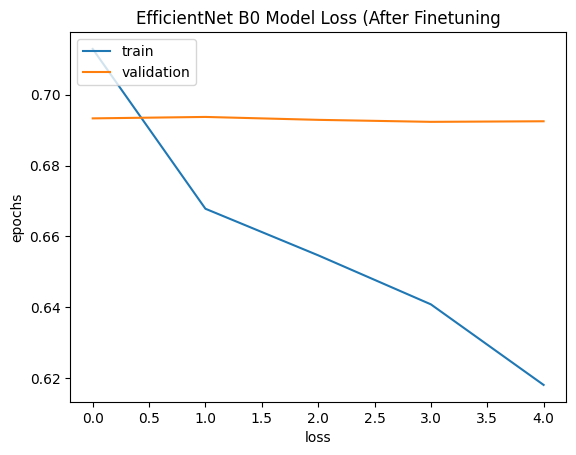

In [55]:
plt.plot(history_finetune_enb0.history['loss'])
plt.plot(history_finetune_enb0.history['val_loss'])
plt.title("EfficientNet B0 Model Loss (After Finetuning")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "validation"], loc="upper left")
plt.show

### Test on new images

In [56]:
import cv2

In [49]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction = detector_enb0.predict(img)
  return "Class 1 (Little to No AI Generation)" if prediction > 0.5 else "Class 0 (Contains Substastantial AI Generation)"

image_path= "aibdaycake.jpg"
result = predict_image(image_path)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Class 1 (Contains AI generation)


In [51]:
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction = detector_enb0.predict(img)
  return "Class 1 (Little to No AI Generation)" if prediction > 0.5 else "Class 0 (Contains Substastantial AI Generation)"

image_path= "/content/skyandplamtrees.jpg"
result = predict_image(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Class 0 (Little to No AI generation detected)


### Calsulate the accuracy

### Make prediction

In [68]:
#get labels
y_true_enb0 = validation_detector_enb0.classes

y_pred_prob_enb0 = detector_enb0.predict(validation_detector_enb0)

y_pred_enb0 = (y_pred_prob_enb0 > 0.5).astype(int).reshape(-1)

#F1 score
f1_enb0 = f1_score(y_true_enb0, y_pred_enb0)
print(f"F-1 Score: {f1_enb0}")

#recall score
recall_enb0 = recall_score(y_true_enb0, y_pred_enb0)
print(f"Recall Score: {recall_enb0}")

#aucroc
auc_enb0 = roc_auc_score(y_true_enb0, y_pred_enb0)
print(f"AUC-ROC: {auc_enb0}")

#precision score
precision_enb0 = precision_score(y_true_enb0, y_pred_enb0)
print(f"Precision Score: {precision_enb0}")

#confusion matrix
conf_matrix = confusion_matrix(y_true_enb0, y_pred_enb0)
print(f"Confusion Matrix:")
print(conf_matrix)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 700ms/step
F-1 Score: 0.30337078651685395
Recall Score: 0.2523364485981308
AUC-ROC: 0.42056074766355134
Precision Score: 0.38028169014084506
Confusion Matrix:
[[63 44]
 [80 27]]


### ROC Curve Plot

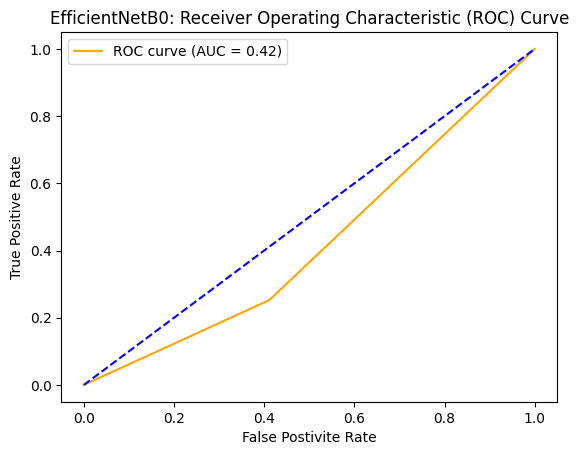

In [84]:
fpr, tpr, thresholds = roc_curve(y_true_enb0, y_pred_enb0)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_enb0:.2f})', color="orange")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Postivite Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNetB0: Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="upper left")
plt.show()

### EfficientNetB3



In [10]:
#load the base
base = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable= False

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.2)(x)
outputlayer = Dense(1, activation = "sigmoid")

In [12]:
detector_enb3 = Model(inputs=base.input, outputs=outputlayer(x))

#compile
detector_enb3.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

detector_enb3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 10,980,400 (41.89 MB)

 Trainable params: 196,865 (769.00 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [13]:
#rescale and normalize data
datagen_train_enb3 = ImageDataGenerator(rescale = 1.0/255, rotation_range = 30, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split= 0.2)

In [17]:
train_detector_enb3 = datagen_train_enb3.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "training")

validation_detector_enb3 = datagen_train_enb3.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "validation")

Found 861 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [18]:
history_enb3 = detector_enb3.fit(train_detector_enb3, epochs=100, validation_data = validation_detector_enb3)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
24/27 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.5294 - loss: 0.7591

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step - accuracy: 0.5265 - loss: 0.7552 - val_accuracy: 0.5000 - val_loss: 0.6949
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 189s 7s/step - accuracy: 0.4993 - loss: 0.6924 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 213s 7s/step - accuracy: 0.4878 - loss: 0.7018 - val_accuracy: 0.5421 - val_loss: 0.6902
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 200s 7s/step - accuracy: 0.4898 - loss: 0.6980 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step - accuracy: 0.4813 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - accuracy: 0.5052 - loss: 0.6962 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step - accuracy: 0.4939 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 194s 7s/step - accuracy: 0.4869 - loss: 0.6942 - val_accuracy: 0.5327 - val_l

Plot the accuracy before finetuning

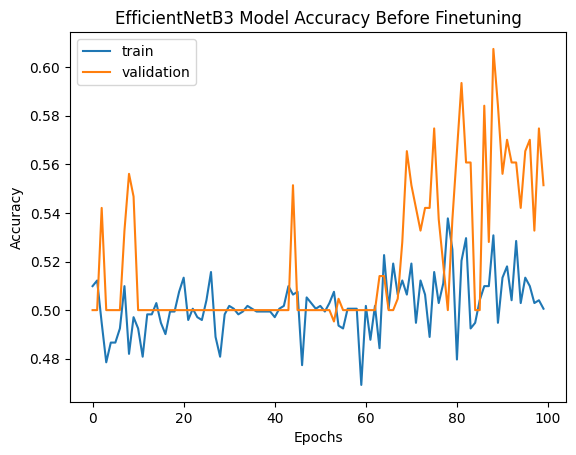

In [21]:
plt.plot(history_enb3.history['accuracy'])
plt.plot(history_enb3.history['val_accuracy'])
plt.title("EfficientNetB3 Model Accuracy Before Finetuning")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### plot loss before finetuning

<function matplotlib.pyplot.show(close=None, block=None)>

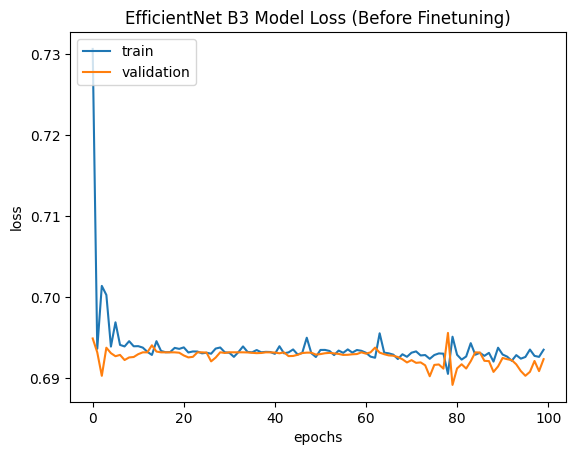

In [22]:
plt.plot(history_enb3.history['loss'])
plt.plot(history_enb3.history['val_loss'])
plt.title("EfficientNet B3 Model Loss (Before Finetuning)")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="upper right")
plt.show


### Fine tune the model (b3)

In [23]:
base.trainable = True

detector_enb3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

history_finetune_enb3= detector_enb3.fit(train_detector_enb3, epochs=5, validation_data = validation_detector_enb3)

Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 242s 8s/step - accuracy: 0.5082 - loss: 0.6925 - val_accuracy: 0.5654 - val_loss: 0.6923
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 241s 7s/step - accuracy: 0.4949 - loss: 0.6931 - val_accuracy: 0.5514 - val_loss: 0.6924
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - accuracy: 0.5516 - loss: 0.6922 - val_accuracy: 0.5514 - val_loss: 0.6924
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step - accuracy: 0.4951 - loss: 0.6934 - val_accuracy: 0.5748 - val_loss: 0.6921
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 197s 7s/step - accuracy: 0.4915 - loss: 0.6931 - val_accuracy: 0.5514 - val_loss: 0.6923


### Accuracy after finetuning

In [24]:
val_loss_enb3, val_accuracy_enb3 = detector_enb3.evaluate(validation_detector_enb3)
print(f"Validation Accuracy: {val_accuracy_enb3:.7f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.5620 - loss: 0.6924
Validation Accuracy: 0.5467290


### plot the accuracy after finetuning

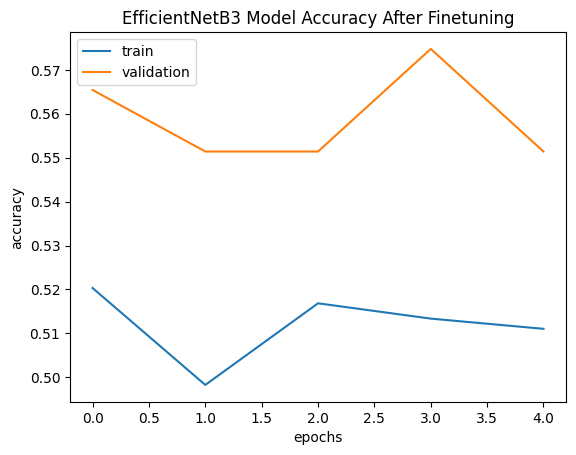

In [26]:
plt.plot(history_finetune_enb3.history['accuracy'])
plt.plot(history_finetune_enb3.history['val_accuracy'])
plt.title("EfficientNetB3 Model Accuracy After Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### Plot loss after finetuning

<function matplotlib.pyplot.show(close=None, block=None)>

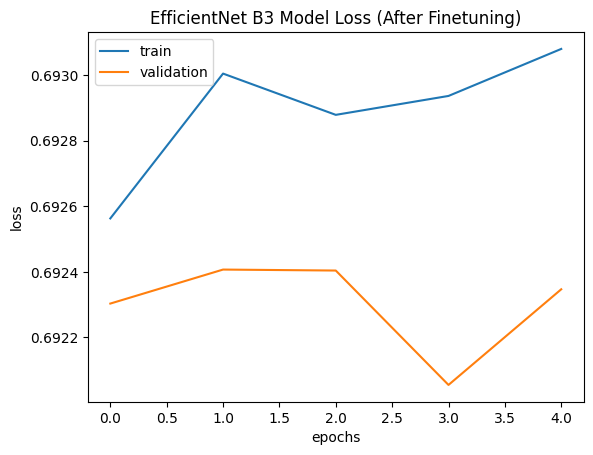

In [28]:
plt.plot(history_finetune_enb3.history['loss'])
plt.plot(history_finetune_enb3.history['val_loss'])
plt.title("EfficientNet B3 Model Loss (After Finetuning)")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="upper left")
plt.show

### Test model on new images

In [43]:
import cv2
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction = detector_enb3.predict(img)
  return "Class 1 (Little to No AI Generation)" if prediction > 0.5 else "Class 0 (Contains Substastantial AI Generation)"

image_path= "aibdaycake.jpg"
result = predict_image(image_path)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Class 0 (Contains Substastantial AI Generation)


In [44]:
import cv2
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction = detector_enb3.predict(img)
  return "Class 1 (Little to No AI Generation)" if prediction > 0.5 else "Class 0 (Contains Substastantial AI Generation)"

image_path= "/content/skyandplamtrees.jpg"
result = predict_image(image_path)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Class 0 (Contains Substastantial AI Generation)


### Calculate accuracy of model

In [33]:
#get labels
y_true_enb3 = validation_detector_enb3.classes

y_pred_prob_enb3 = detector_enb3.predict(validation_detector_enb3)

y_pred_enb3 = (y_pred_prob_enb3 > 0.5).astype(int).reshape(-1)

#F1 score
f1_enb3 = f1_score(y_true_enb3, y_pred_enb3)
print(f"F-1 Score: {f1_enb3}")

#recall score
recall_enb3 = recall_score(y_true_enb3, y_pred_enb3)
print(f"Recall Score: {recall_enb3}")

#aucroc
auc_enb3 = roc_auc_score(y_true_enb3, y_pred_enb3)
print(f"AUC-ROC: {auc_enb3}")

#precision score
precision_enb3 = precision_score(y_true_enb3, y_pred_enb3)
print(f"Precision Score: {precision_enb3}")

#confusion matrix
conf_matrix_enb3 = confusion_matrix(y_true_enb3, y_pred_enb3)
print(f"Confusion Matrix:")
print(conf_matrix_enb3)

5/7 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 6s/step
F-1 Score: 0.2222222222222222
Recall Score: 0.14018691588785046
AUC-ROC: 0.5093457943925234
Precision Score: 0.5357142857142857
Confusion Matrix:
[[94 13]
 [92 15]]


### ROC Curve Plot

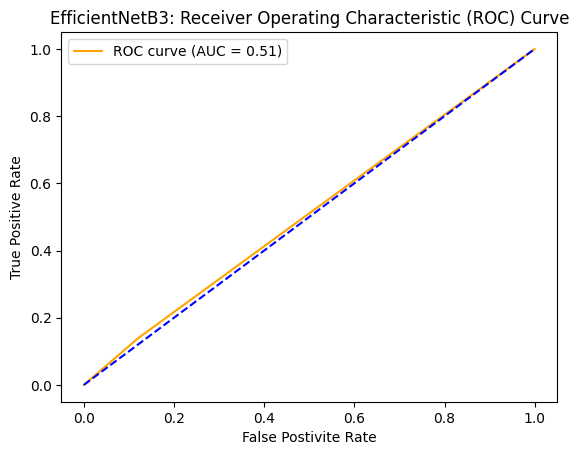

In [34]:
fpr, tpr, thresholds = roc_curve(y_true_enb3, y_pred_enb3)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_enb3:.2f})', color="orange")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Postivite Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNetB3: Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="upper left")
plt.show()

# EfficientnetV2S

In [60]:
#load the base
base = tf.keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable = False

In [61]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(x)

In [66]:
from tensorflow.keras.optimizers import Adam
detector_env2s = Model(inputs=base.input, outputs=outputlayer(x))

#compile
detector_env2s.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy', metrics=['accuracy'])

detector_env2s.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_9 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├──────────────────────

 Total params: 20,495,457 (78.18 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [49]:
#rescale and normalize data
datagen_train_env2s = ImageDataGenerator(rescale = 1.0/255, rotation_range = 30, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split= 0.2)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the base EfficientNetV2S model
base = tf.keras.applications.EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base.trainable = False  # Freeze the convolutional base

# Build custom head
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification

# Define the model
detector_env2s = Model(inputs=base.input, outputs=output)

# Compile the model
detector_env2s.compile(optimizer=Adam(learning_rate=1e-4),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

detector_env2s.summary()

# Set up image data pipeline using tf.data
AUTOTUNE = tf.data.AUTOTUNE

# Function to process images (resize, rescale, etc.)
def process_image(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0  # Rescale images to [0, 1]
    return image, label

# Load the dataset (use your own directory)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/imagedataset/imagedataset/dataset/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/imagedataset/imagedataset/dataset/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Process images (data augmentation and rescaling) on the fly
train_ds = train_ds.map(process_image)
val_ds = val_ds.map(process_image)

# Cache and prefetch data for better performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train the model
history_env2s = detector_env2s.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds
)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_10 (Rescaling)  │ (None, 224, 224, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├──────────────────────

 Total params: 20,495,457 (78.18 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

Found 1076 files belonging to 2 classes.
Using 861 files for training.
Found 1076 files belonging to 2 classes.
Using 215 files for validation.
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 339s 10s/step - accuracy: 0.4824 - loss: 0.6968 - val_accuracy: 0.5302 - val_loss: 0.6898
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 193s 7s/step - accuracy: 0.5151 - loss: 0.6942 - val_accuracy: 0.5163 - val_loss: 0.6897
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 187s 7s/step - accuracy: 0.5445 - loss: 0.6881 - val_accuracy: 0.5163 - val_loss: 0.6870
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 203s 7s/step - accuracy: 0.5349 - loss: 0.6854 - val_accuracy: 0.5349 - val_loss: 0.6868
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.5344 - loss: 0.6824 - val_accuracy: 0.5349 - val_loss: 0.6846
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.5273 - loss: 0.6890 - val_accuracy: 0.5349 - val_loss: 0.6809
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 207s 7s/step - accuracy: 0.5877 - loss: 0.6777 -

In [50]:
train_detector_env2s = datagen_train_env2s.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "training")

validation_detector_env2s = datagen_train_env2s.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "validation")

Found 861 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [59]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# history_env2s = detector_env2s.fit(train_detector_env2s, epochs=100, validation_data = validation_detector_env2s, use_multiprocessing=True, shuffle=True, verbrose=1)

TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'use_multiprocessing'

### Plot accuracy before finetuning

In [ ]:
plt.plot(history_env2s.history['accuracy'])
plt.plot(history__env2s.history['val_accuracy'])
plt.title("EfficientNetV2S Model Accuracy Before Finetuning")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### Plot loss before finetuning

In [ ]:
plt.plot(history_env2s.history['loss'])
plt.plot(history_enbv2s.history['val_loss'])
plt.title("EfficientNetV2s Model Loss (Before Finetuning)")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="upper left")
plt.show

### Finetune the model (V2S)

In [ ]:
base.trainable = True

detector_env2s.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])

history_finetune_env2s= detector_env2s.fit(train_detector_enbv2s, epochs=5, validation_data = val_ds)

### Accuracy after finetuning

In [ ]:
val_loss_env2s, val_accuracy_env2s = detector_env2s.evaluate(validation_detector_env2s)
print(f"Validation Accuracy: {val_accuracy_env2s:.7f}")

### Plot the accuracy after finetuning

In [ ]:
plt.plot(history_finetune_env2s.history['accuracy'])
plt.plot(history_finetune_env2s.history['val_accuracy_env2s'])
plt.title("EfficientNetV2S Model Accuracy After Finetuning")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc = "upper left")
plt.show()

### Plot loss after finetuning

In [ ]:
plt.plot(history_finetune_env2s.history['loss'])
plt.plot(history_finetune_env2s.history['val_loss_env2s'])
plt.title("EfficientNetv2s Model Loss (After Finetuning)")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend(["train", "validation"], loc="upper left")
plt.show

### Test model on new images

In [ ]:
import cv2
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction = detector_env2s.predict(img)
  return "Class 1 (Contains AI generation)" if prediction > 0.5 else "Class 0 (Little to No AI generation detected)"

image_path= "aibdaycake.jpg"
result = predict_image(image_path)
print(result)

Real portrait

In [ ]:
import cv2
def predict_image(image_path):
  img= cv2.imread(image_path)
  img = cv2.resize(img,(224, 224)) / 255.0
  img= np.expand_dims(img, axis=0)
  prediction = detector_env2s.predict(img)
  return "Class 1 (Contains AI generation)" if prediction > 0.5 else "Class 0 (Little to No AI generation detected)"

image_path= "/content/skyandplamtrees.jpg"
result = predict_image(image_path)
print(result)

### Calculate the accuracy and additional scores of the model

In [ ]:
#get labels
y_true_env2s = validation_detector_env2s.classes

y_pred_prob_env2s = detector_env2s.predict(validation_detector_env2s)

y_pred_env2s = (y_pred_prob_env2s > 0.5).astype(int).reshape(-1)

#F1 score
f1_env2s = f1_score(y_true_env2s, y_pred_env2s)
print(f"F-1 Score: {f1_env2s}")

#recall score
recall_env2s = recall_score(y_true_env2s, y_pred_env2s)
print(f"Recall Score: {recall_env2s}")

#aucroc
auc_env2s = roc_auc_score(y_true_env2s, y_pred_env2s)
print(f"AUC-ROC: {auc_env2s}")

#precision score
precision_env2s = precision_score(y_true_env2s, y_pred_env2s)
print(f"Precision Score: {precision_env2s}")

#confusion matrix
conf_matrix_env2s = confusion_matrix(y_true_env2s, y_pred_env2s)
print(f"Confusion Matrix:")
print(conf_matrix_env2s)

### Plot ROC Curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true_env2s, y_pred_env2s)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_env2s:.2f})', color="orange")
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel("False Postivite Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNetV2S: Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="upper left")
plt.show()

## VGG16 Model

In [40]:
#rescale and normalize data
datagen_train_enb0 = ImageDataGenerator(rescale = 1.0/255, rotation_range = 30, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split= 0.2)

In [13]:
dataset_path = "/content/imagedataset/imagedataset/dataset/"

In [11]:
#validation split 80/20 split
data_gen_vgg= ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

In [14]:
#load training data
train_data_vgg = data_gen_vgg.flow_from_directory(directory = dataset_path, target_size=(224, 224), batch_size=32, class_mode= "binary", subset = "training", shuffle=True)

test_data_vgg = data_gen_vgg.flow_from_directory(directory = dataset_path, target_size=(224, 224), batch_size=32, class_mode="binary", subset = "validation", shuffle = False)

Found 861 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


### create an object for training and testing data

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

detector_vgg = Sequential()
detector_vgg.add(Conv2D(input_shape=(224, 224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
detector_vgg.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation = "relu"))
detector_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
detector_vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
detector_vgg.add(Conv2D(filters = 128, kernel_size=(3,3), padding="same", activation="relu"))
detector_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
detector_vgg.add(Conv2D(filters=256, kernel_size=(3,3), padding = "same", activation = "relu"))
detector_vgg.add(Conv2D(filters=256, kernel_size=(3, 3), padding = "same", activation ="relu"))
detector_vgg.add(Conv2D(filters=256, kernel_size=(3,3), padding = "same", activation="relu"))
detector_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation ="relu"))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation = "relu"))
detector_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding= "same", activation = "relu"))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation = "relu"))
detector_vgg.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation = "relu"))
detector_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))


#initialize the model
detector_vgg.add(Flatten())
detector_vgg.add(Dense(units=4096, activation="relu"))
detector_vgg.add(Dense(units=4096, activation="relu"))
detector_vgg.add(Dense(units=2, activation="softmax"))
detector_vgg.add(Dense(units=1, activation ="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### compile model

In [23]:
from keras.optimizers import Adam

optim = Adam(learning_rate=0.001)
detector_vgg.compile(optimizer=optim, loss = "binary_crossentropy", metrics=['accuracy'])

detector_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,741 (512.19 MB)

 Trainable params: 134,268,741 (512.19 MB)

 Non-trainable params: 0 (0.00 B)

### Using TFRecord Dataset for VGG-16

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [30]:
image_size = (224, 224)
batch_size = 32
autotune = tf.data.AUTOTUNE
classes = 2

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
check_point = ModelCheckpoint("vgg16_1.h5", monitor="validation_accuracy", verbose=1, save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
early_stop = EarlyStopping(monitor="validation_accuracy", min_delta=0, patience=20, verbose=1, mode="max")
history = detector_vgg.fit(steps_per_epoch=100, x=train_data_vgg, validation_data = test_data_vgg, validation_steps = 10, epochs = 10, callbacks=[check_point, early_stop])

Epoch 1/10
 16/100 ━━━━━━━━━━━━━━━━━━━━ 1:36:44 69s/step - accuracy: 0.4970 - loss: 0.6960

KeyboardInterrupt: 

### Testing Accuracy

In [ ]:
val_loss, val_accuracy = detector_vgg.evaluate(validation_detector_vgg)
print(f"Validation Accuracy: {val_accuracy:.7f}")

In [ ]:
#unzip file
import zipfile

with zipfile.ZipFile("/content/imagedataset.zip", "r") as dataset:
  dataset.extractall("/content/imagedataset/")

train_detector_vgg= datagen_train.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "training")

validation_detector_vgg = datagen_train.flow_from_directory("/content/imagedataset/imagedataset/dataset/", target_size=(224, 224), batch_size=32, class_mode = "binary", subset = "validation")

FileNotFoundError: [Errno 2] No such file or directory: '/content/imagedataset.zip'

In [ ]:
# #import the libraries
# import tensorflow as tf
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt
# import numpy as np
# import os

# base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base.trainable= False

In [ ]:
# #install required libraries
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.image import imread
# import tensorflow_hub as hub
# import tf_keras
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras import layers, models
# import keras
# from keras.models import Sequential
# from keras.layers import InputLayer

# #load efficientnet
# base=hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/classification/1")
# base.trainable = False

In [ ]:
# #sequential model
# model= tf_keras.Sequential()
# #add efficientnet
# model.add(base)
# #add global average pooling layer
# model.add(layers.GlobalAveragePooling2D())
# #add a dense layer for classification
# model.add(layers.Dense(num_classes=2, activation="softmax"))

In [ ]:
# from matplotlib import pyplot
# import matplotlib.pyplot as plt
# from matplotlib.image import imread
# from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import Dense, Dropout, Flatten
# # from keras.optimizers import SGD
# from keras.models import Model
# from keras.src.legacy.preprocessing.image import ImageDataGenerator

# folder = 'dataset/'

In [ ]:
# def displayImages(foldername, aiorreal, startID):
#   # for i in range(9):
#     pyplot.subplot(330 + 1 + i)
#     filename